In [101]:
!python -m pip install torch torchvision torchaudio matplotlib pandas graphviz onnx onnxscript onnxruntime ndjson scikit-learn tensorboard


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [102]:
import ndjson
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import tensorboard

In [103]:
# Regardons à quoi ressemble le dataset

with open("datasets/sheep.ndjson") as f:
    reader = ndjson.reader(f)
    print(reader.next())

{'word': 'sheep', 'countrycode': 'SE', 'timestamp': '2017-03-28 07:09:01.69625 UTC', 'recognized': True, 'key_id': '4609015428415488', 'drawing': [[[59, 59, 52, 50, 44], [203, 192, 170, 135, 119]], [[152, 159, 161, 161, 148], [207, 207, 204, 189, 132]], [[138, 140, 136, 113, 127, 101, 78, 76, 85, 82, 62, 37, 27, 27, 15, 7, 1, 1, 5, 17, 29, 39, 36, 31, 30, 33, 50, 69, 87, 104, 113, 127, 134, 136, 143, 160, 165, 177, 179], [133, 137, 139, 139, 133, 143, 145, 134, 114, 111, 122, 126, 109, 69, 70, 63, 49, 32, 26, 23, 24, 32, 31, 24, 11, 7, 1, 0, 5, 25, 23, 11, 9, 24, 36, 23, 44, 56, 79]], [[133, 149, 182, 189, 188, 214, 215, 211], [150, 138, 132, 128, 117, 115, 95, 88]], [[184, 224, 242, 253, 254], [85, 70, 58, 36, 12]], [[246, 246, 255], [16, 3, 14]]]}


In [104]:
# à la différence de MNIST où on avait un tuple (tensor, result), ici on devra convertir nous mêmes ces valeurs avec :
# result -> word ; tensor -> drawing

# On va utiliser le dataset Quick Draw de google, préparons une classe pour charger les fichiers ndjson
class QuickDrawDataset(Dataset):
    def __init__(self, file, transform):
        self.data = []
        self.transform = transform
        self.trueish = 0
        self.falseish = 0
        
        with open(file, "r") as f:
            reader = ndjson.reader(f)
            for item in reader:
                image = self._convert_to_image(item["drawing"])
                recognized = item['recognized']
                if recognized:
                    # if self.trueish > 8000:
                    #     continue
                    self.trueish +=1
                else:
                    self.falseish +=1
                self.data.append((image, recognized))

        print('Done !')

    def _convert_to_image(self, drawing):
        canvas = np.zeros((28, 28), dtype=np.float32)
        for stroke in drawing:
            x_coords, y_coords = stroke
            for x, y in zip(x_coords, y_coords):
                x = int((x / 255) * 27)
                y = int((y / 255) * 27)
                canvas[y, x] = 1
        return canvas

    def __len__(self):
        return len(self.data)

    # on applique notre transform à la demande
    def __getitem__(self, idx):
        data, recognized = self.data[idx]
        return (self.transform(data), recognized)

In [105]:
dataset = QuickDrawDataset(
    file="datasets/sheep.ndjson",
    transform=T.ToTensor()
)
print(f'Balance : {dataset.trueish} True / {dataset.falseish} False')

Done !
Balance : 117555 True / 8566 False


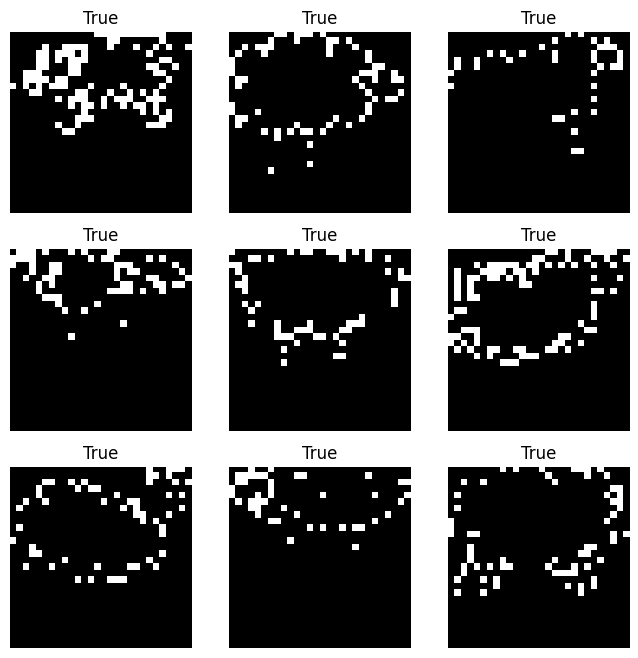

In [106]:
#affichons les premières images

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [107]:
# Les images sont sur un format très similaire à ce qu'on a utilisé, on peut suivre la trame utilisée pour MNIST

from torch.utils.data import DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size, shuffle=True)

for images, labels in dataloader:
    print(images.shape)
    print(labels.shape)
    break


torch.Size([64, 1, 28, 28])
torch.Size([64])


In [108]:
mean, std = 0, 0

for image, label in dataloader:
    image = image.view(image.size(0), -1)
    mean+= image.mean().sum()
    std+= image.std().sum()

mean /= len(dataloader)
std /= len(dataloader)

print (f'Mean: {mean}')
print (f'Variance: {std}')

Mean: 0.07875107228755951
Variance: 0.2692717909812927


In [109]:
# On peut affiner le dataset 

cleaned_dataset = QuickDrawDataset(
    file="datasets/sheep.ndjson",
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

# Les images sont sur un format très similaire à ce qu'on a utilisé, on peut suivre la trame utilisée pour MNIST

from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset)) 
test_size = len(dataset) - train_size

training_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(training_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(training_dataset, batch_size, shuffle=False)

Done !


In [110]:
# Importons de quoi faire une Epoch

In [111]:
from torch.utils.tensorboard import SummaryWriter

device = "mps" if torch.mps.is_available() else "cpu"
writer = SummaryWriter('runs/sheep_experiment')

def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        # Test the model
        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")

In [112]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_stack_activation = nn.ReLU
        self.mlp_activation = nn.ReLU

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            self.conv_stack_activation(),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            self.conv_stack_activation(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 * 28 * 28 -> 64 * 14 * 14
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            self.mlp_activation(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            self.mlp_activation(),
            nn.Dropout(0.2),
            nn.Linear(128, 2), # mouton ou pas mouton
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x

In [113]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)

In [114]:
epochs = 5
train_and_test(train_dataloader, test_dataloader, cnn, loss_fn, optimizer, epochs, batch_size)

Epoch 1/5
Epoch 1/5 complete

Epoch 2/5
Epoch 2/5 complete

Epoch 3/5
Epoch 3/5 complete

Epoch 4/5
Epoch 4/5 complete

Epoch 5/5
Epoch 5/5 complete



In [115]:
!tensorboard --logdir=runs/sheep_experiment

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [116]:
# Transformation pour avoir un modele exportable

cnn.to("cpu")

torch_input = torch.randn(1, 1, 28, 28) # N, C, L, T

onn_program = torch.onnx.export(
    cnn,
    torch_input,
    "model.onnx",
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    opset_version=11, # /!\ 
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batchs_size"},
    }
)

Exported graph: graph(%input : Float(*, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv_stack.0.weight : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.0.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.3.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_stack.3.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.weight : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %conv_stack.6.running_mean : Float(64, strides=[1], requires_grad=0, device=cpu),
      %conv_stack.6.running_var : Float(64, strides=[1], requires_grad=0, device=cpu),
      %mlp.1.weight : Float(128, 12544, strides=[12544, 1], requires_grad=1, device=cpu),
      %mlp.1.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %mlp.4.weight : Float(